### 1.Импорты

In [277]:
import os 
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np # Может понадобиться для преобразования типов
import torch.nn.functional as F # Часто используется для функций активации, если они не как отдельные слои
from torch.optim.lr_scheduler import ReduceLROnPlateau # Импортируем планировщик

### 2.Загрузка данных

In [278]:
PATH = "data"

pd.set_option('display.width', 1000) # Для того чтобы выводилась таблица без переносов

# Используем os.path.join для кроссплатформенности, так как в linux и windows по разному строятся пути к файлам
FILETEST = os.path.join(PATH, "test.csv")    
FILETRAIN = os.path.join(PATH, "train.csv") 

# 2. Создаем словарь для перевода названий столбцов
column_translation = {
    'Survived': 'Выжил',
    'Pclass': 'Класс Билета',
    'Name': 'Имя',
    'Sex': 'Пол',
    'Age': 'Возраст',
    'SibSp': 'Братьев/Сестер/Супругов на борту',
    'Parch': 'Родителей/Детей на борту',
    'Ticket': 'Номер Билета',
    'Fare': 'Тариф',
    'Cabin': 'Каюта',
    'Embarked': 'Порт Посадки'
}

try:
    df_train = pd.read_csv(FILETRAIN)
    df_test = pd.read_csv(FILETEST)

    df_test_original = df_test.copy()

    df_train.drop('PassengerId', axis=1, inplace=True)
    df_test.drop('PassengerId', axis=1, inplace=True)

    # Переименовываем столбцы для удобства
    df_train.rename(columns=column_translation, inplace=True, errors='ignore')
    df_test.rename(columns=column_translation, inplace=True, errors='ignore')


    print("Данные успешно загружены!")
    print("\nПервые 5 строк тренировочного набора:")
    print(df_train.head())
    print(f"\nРазмер тренировочного набора: {df_train.shape}")
    print(f"Размер тестового набора: {df_test.shape}")
except FileNotFoundError:
    print(f"Ошибка: Один из файлов не найден. Проверьте пути:\n- {FILETRAIN}\n- {FILETEST}")
except Exception as e:
    print(f"Произошла ошибка при загрузке данных: {e}")


Данные успешно загружены!

Первые 5 строк тренировочного набора:
   Выжил  Класс Билета                                                Имя     Пол  Возраст  Братьев/Сестер/Супругов на борту  Родителей/Детей на борту      Номер Билета    Тариф Каюта Порт Посадки
0      0             3                            Braund, Mr. Owen Harris    male     22.0                                 1                         0         A/5 21171   7.2500   NaN            S
1      1             1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female     38.0                                 1                         0          PC 17599  71.2833   C85            C
2      1             3                             Heikkinen, Miss. Laina  female     26.0                                 0                         0  STON/O2. 3101282   7.9250   NaN            S
3      1             1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female     35.0                                 1                       

In [279]:
df_train.info()
df_test.info()
df_train.describe()
df_train.describe()

passengers_with_missing_age = df_train[df_train['Возраст'].isnull()]

print(f"Всего пассажиров с пропущенным возрастом: {len(passengers_with_missing_age)}")
print("\nИнформация о первых нескольких пассажирах с пропущенным возрастом:")

# Выведем, например, первые 10 таких пассажиров
# Вы можете изменить .head(10) на другое число или использовать .sample(10) для случайных
print(passengers_with_missing_age.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Выжил                             891 non-null    int64  
 1   Класс Билета                      891 non-null    int64  
 2   Имя                               891 non-null    object 
 3   Пол                               891 non-null    object 
 4   Возраст                           714 non-null    float64
 5   Братьев/Сестер/Супругов на борту  891 non-null    int64  
 6   Родителей/Детей на борту          891 non-null    int64  
 7   Номер Билета                      891 non-null    object 
 8   Тариф                             891 non-null    float64
 9   Каюта                             204 non-null    object 
 10  Порт Посадки                      889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB
<class 'panda

### Извлечение дополнительных признаков, исправление коллизий

In [280]:
# Извлекаем Фамилию
# Фамилия - это всё до первой запятой
df_train['Фамилия'] = df_train['Имя'].apply(lambda name: name.split(',')[0].strip())
df_test['Фамилия'] = df_test['Имя'].apply(lambda name: name.split(',')[0].strip())

# Извлекаем Статус (Титул)
df_train['Титул'] = df_train['Имя'].str.extract(r',\s*([A-Za-z]+)\.', expand=False)
df_test['Титул'] = df_test['Имя'].str.extract(r',\s*([A-Za-z]+)\.', expand=False)

# Стандартизируем статусы
list_of_rare_titles = ['Dr', 'Rev', 'Major', 'Col', 'Don', 'Lady', 'Sir', 'Capt', 'Jonkheer', 'Dona', 'Countess'] # Добавил Countess на всякий случай, если она где-то пропущена была

# Стандартизация для df_train
df_train['Титул'] = df_train['Титул'].replace(list_of_rare_titles, 'Rare')
df_train['Титул'] = df_train['Титул'].replace(['Mlle', 'Ms'], 'Miss') # Mlle и Ms становятся Miss
df_train['Титул'] = df_train['Титул'].replace('Mme', 'Mrs')      # Mme становится Mrs

# Стандартизация для df_test
df_test['Титул'] = df_test['Титул'].replace(list_of_rare_titles, 'Rare')
df_test['Титул'] = df_test['Титул'].replace(['Mlle', 'Ms'], 'Miss')
df_test['Титул'] = df_test['Титул'].replace('Mme', 'Mrs')

print("\nУникальные титулы в тренировочном наборе и их количество:")
print(df_train['Титул'].value_counts())

print("\nУникальные титулы в тестовом наборе и их количество:")
print(df_test['Титул'].value_counts())

# Заполнение пропусков в Fare в тестовом наборе 
if df_test['Возраст'].isnull().any():
    age_median_train = df_train['Возраст'].median()
    df_test['Возраст'] = df_test['Возраст'].fillna(age_median_train)
    print(f"Пропуски в 'Возраст' df_test заполнены медианой из df_train: {age_median_train}")

# Удаляем Имя
df_train.drop('Имя', axis=1, inplace=True)
df_test.drop('Имя', axis=1, inplace=True)

if df_test['Тариф'].isnull().any():
    fare_median_train = df_train['Тариф'].median()
    df_test['Тариф'] = df_test['Тариф'].fillna(fare_median_train)
    print(f"Пропуски в 'Тариф' df_test заполнены медианой из df_train: {fare_median_train}")


Уникальные титулы в тренировочном наборе и их количество:
Титул
Mr        517
Miss      185
Mrs       126
Master     40
Rare       22
Name: count, dtype: int64

Уникальные титулы в тестовом наборе и их количество:
Титул
Mr        240
Miss       79
Mrs        72
Master     21
Rare        6
Name: count, dtype: int64
Пропуски в 'Возраст' df_test заполнены медианой из df_train: 28.0
Пропуски в 'Тариф' df_test заполнены медианой из df_train: 14.4542


In [281]:
df_train.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Выжил                             891 non-null    int64  
 1   Класс Билета                      891 non-null    int64  
 2   Пол                               891 non-null    object 
 3   Возраст                           714 non-null    float64
 4   Братьев/Сестер/Супругов на борту  891 non-null    int64  
 5   Родителей/Детей на борту          891 non-null    int64  
 6   Номер Билета                      891 non-null    object 
 7   Тариф                             891 non-null    float64
 8   Каюта                             204 non-null    object 
 9   Порт Посадки                      889 non-null    object 
 10  Фамилия                           891 non-null    object 
 11  Титул                             890 non-null    object 
dtypes: float

### Удаление строк с недостающими данными.

Как видно из вывода выше у нас у 2 пассажиров нет данных по порту посадки и у 1 нет титула. Проще всего удалить эти строки. Использовать будем метод `.drona`

In [282]:
df_train.dropna(subset=['Порт Посадки', 'Титул'], inplace=True)
df_train.info()

# Пока что удалим людей без возраста 
df_train.dropna(subset=['Возраст'], inplace=True)

print("\nПервые 5 строк тренировочного набора:")
print(df_train.head())
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 888 entries, 0 to 890
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Выжил                             888 non-null    int64  
 1   Класс Билета                      888 non-null    int64  
 2   Пол                               888 non-null    object 
 3   Возраст                           711 non-null    float64
 4   Братьев/Сестер/Супругов на борту  888 non-null    int64  
 5   Родителей/Детей на борту          888 non-null    int64  
 6   Номер Билета                      888 non-null    object 
 7   Тариф                             888 non-null    float64
 8   Каюта                             201 non-null    object 
 9   Порт Посадки                      888 non-null    object 
 10  Фамилия                           888 non-null    object 
 11  Титул                             888 non-null    object 
dtypes: float64(2)

### Работа с билетами
Также некоторые билеты перед номером имеют буквенное обозначение которое явно что-то обозначает. Думаю стоит создать отдельный столбец с этим обозначением. Для всех у кого нет этого обозначения можно обозначить текстом "none".

In [283]:

column_ticket = df_train['Номер Билета']

df_train['Префикс Билета'] = df_train['Номер Билета'].apply(
    lambda name: (
        'NONE' 
        if (name.split(' ')[0].strip() == name.split(' ')[-1].strip())
        else name.split(' ')[0].strip()
    )
)
df_test['Префикс Билета'] = df_test['Номер Билета'].apply(
    lambda name: (
        'NONE' 
        if (name.split(' ')[0].strip() == name.split(' ')[-1].strip())
        else name.split(' ')[0].strip()
    )
)

df_train['Серия Билета'] = df_train['Номер Билета'].apply(lambda name: name.split(' ')[-1].strip())
df_test['Серия Билета'] = df_test['Номер Билета'].apply(lambda name: name.split(' ')[-1].strip())


df_train['Префикс Билета'] = df_train['Префикс Билета'].str.upper()
df_train['Префикс Билета'] = df_train['Префикс Билета'].str.replace('.', '', regex=False)
df_train['Префикс Билета'] = df_train['Префикс Билета'].str.replace('/', '', regex=False)

df_test['Префикс Билета'] = df_test['Префикс Билета'].str.upper()
df_test['Префикс Билета'] = df_test['Префикс Билета'].str.replace('.', '', regex=False)
df_test['Префикс Билета'] = df_test['Префикс Билета'].str.replace('/', '', regex=False)

def normalize_prefix(current_prefix_value):
    if not isinstance(current_prefix_value, str): # Обработка NaN или не-строк
        return current_prefix_value 

    for pref_target in list_pref:
        if pref_target in current_prefix_value: # Проверяем, содержится ли pref_target в текущем значении
            return pref_target # Если да, возвращаем "канонический" префикс из list_pref
    return current_prefix_value

list_pref = ['SOTON', 'STON', 'PARIS','PP', 'A4', 'A5']
df_train['Префикс Билета'] = df_train['Префикс Билета'].apply(lambda name: normalize_prefix(name))
df_test['Префикс Билета'] = df_test['Префикс Билета'].apply(lambda name: normalize_prefix(name))

# Определяем редкие префиксы (например, те, что встречаются менее N раз)
# Подберите N экспериментально, например, 5 или 10
threshold = 5 

prefix_counts_train = df_train['Префикс Билета'].value_counts()
rare_prefixes_train = prefix_counts_train[prefix_counts_train < threshold].index.tolist()
df_train['Префикс Билета'] = df_train['Префикс Билета'].apply(lambda x: 'RARE' if x in rare_prefixes_train else x)

# Для df_test: используем список редких префиксов, полученный из ТРЕНИРОВОЧНОГО набора
# Любой префикс в тестовом наборе, которого не было в частых префиксах тренировочного, также считаем редким
frequent_prefixes_train = prefix_counts_train[prefix_counts_train >= threshold].index.tolist()
if 'NONE' not in frequent_prefixes_train and 'NONE' in df_train['Префикс Билета'].unique(): # Убедимся, что NONE есть
    frequent_prefixes_train.append('NONE')

df_test['Префикс Билета'] = df_test['Префикс Билета'].apply(lambda x: x if x in frequent_prefixes_train else 'RARE')

# Приведение пола к bool


print("\nУникальные префиксы в тестовом наборе и их количество:")
print(df_test['Префикс Билета'].value_counts())
print(df_train['Префикс Билета'].value_counts())
print("\nПервые 5 строк тренировочного набора:")
print(df_train.head())


Уникальные префиксы в тестовом наборе и их количество:
Префикс Билета
NONE     296
PC        32
CA        27
RARE      11
SOTON     10
PARIS      8
A5         7
WC         5
PP         5
A4         4
STON       4
FCC        4
C          3
SOC        2
Name: count, dtype: int64
Префикс Билета
NONE     522
PC        50
CA        33
A5        18
STON      18
SOTON     13
RARE      11
PP         9
PARIS      9
WC         7
SOC        6
A4         5
C          5
FCC        5
Name: count, dtype: int64

Первые 5 строк тренировочного набора:
   Выжил  Класс Билета     Пол  Возраст  Братьев/Сестер/Супругов на борту  Родителей/Детей на борту      Номер Билета    Тариф Каюта Порт Посадки    Фамилия Титул Префикс Билета Серия Билета
0      0             3    male     22.0                                 1                         0         A/5 21171   7.2500   NaN            S     Braund    Mr             A5        21171
1      1             1  female     38.0                                 1    

### Приведение типов данных

In [284]:
mapping = {'male': 0, 'female': 1}
df_train['Пол'] = df_train['Пол'].map(mapping)
df_test['Пол'] = df_test['Пол'].map(mapping)
df_train['Палуба'] = df_train['Каюта'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'U')
df_test['Палуба'] = df_test['Каюта'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'U')

df_train.drop('Каюта', axis=1, inplace=True)
df_test.drop('Каюта', axis=1, inplace=True)
df_train.drop('Номер Билета', axis=1, inplace=True)
df_test.drop('Номер Билета', axis=1, inplace=True)

df_train['Серия Билета'] = df_train['Серия Билета'].str.replace("LINE", '0', regex=False)
df_train['Серия Билета'] = df_train['Серия Билета'].astype(int)
df_test['Серия Билета'] = df_test['Серия Билета'].str.replace("LINE", '0', regex=False)
df_test['Серия Билета'] = df_test['Серия Билета'].astype(int)

print("\nПервые 5 строк тренировочного набора:")
print(df_train.head(11))
df_train.info()


Первые 5 строк тренировочного набора:
    Выжил  Класс Билета  Пол  Возраст  Братьев/Сестер/Супругов на борту  Родителей/Детей на борту    Тариф Порт Посадки    Фамилия   Титул Префикс Билета  Серия Билета Палуба
0       0             3    0     22.0                                 1                         0   7.2500            S     Braund      Mr             A5         21171      U
1       1             1    1     38.0                                 1                         0  71.2833            C    Cumings     Mrs             PC         17599      C
2       1             3    1     26.0                                 0                         0   7.9250            S  Heikkinen    Miss           STON       3101282      U
3       1             1    1     35.0                                 1                         0  53.1000            S   Futrelle     Mrs           NONE        113803      C
4       0             3    0     35.0                                 0               

### Подготовка таблиц к обучению

In [285]:
# Целевая переменная
target = 'Выжил' # Или 'Выжил', если вы переименовали. Делаем вывод - Задача бинарной классификации


# Список числовых признаков, которые уже готовы к использованию
numerical_features = ['Класс Билета','Пол', 'Возраст', 'Братьев/Сестер/Супругов на борту', 'Родителей/Детей на борту', 'Тариф', 'Серия Билета'] 
# Добавьте 'Серия Билета', если считаете ее полезной и она числовая.
# Добавьте 'Pclass', он уже числовой, но по сути категориальный с порядком.

# Список категориальных признаков, которые нужно будет закодировать
# categorical_features = ['Порт Посадки', 'Титул', 'Префикс Билета', 'Палуба']
categorical_features = ['Титул', 'Палуба']


df_train_processed = df_train.copy()
df_test_processed = df_test.copy()

print(f"\nРазмер df_train_processed до get_dummies: {df_train_processed.shape}")
print(f"Размер df_test_processed до get_dummies: {df_test_processed.shape}")

# Применяем One-Hot Encoding к категориальным признакам
# drop_first=True помогает избежать мультиколлинеарности (избыточности)
# и уменьшает количество создаваемых признаков на 1 для каждой категории.
df_train_processed = pd.get_dummies(df_train_processed, columns=categorical_features, drop_first=True, dtype=int)
df_test_processed = pd.get_dummies(df_test_processed, columns=categorical_features, drop_first=True, dtype=int)

df_train_processed.drop('Фамилия', axis=1, inplace=True)
df_test_processed.drop('Фамилия', axis=1, inplace=True)

df_train_processed.drop('Серия Билета', axis=1, inplace=True)
df_test_processed.drop('Серия Билета', axis=1, inplace=True)

df_train_processed.drop('Префикс Билета', axis=1, inplace=True)
df_test_processed.drop('Префикс Билета', axis=1, inplace=True)


df_train_processed.drop('Порт Посадки', axis=1, inplace=True)
df_test_processed.drop('Порт Посадки', axis=1, inplace=True)

# df_train_processed.drop('Братьев/Сестер/Супругов на борту', axis=1, inplace=True)
# df_test_processed.drop('Братьев/Сестер/Супругов на борту', axis=1, inplace=True)

# df_train_processed.drop('Родителей/Детей на борту', axis=1, inplace=True)
# df_test_processed.drop('Родителей/Детей на борту', axis=1, inplace=True)

# df_train_processed.drop('Палуба', axis=1, inplace=True)
# df_test_processed.drop('Палуба', axis=1, inplace=True)
df_train_processed = df_train_processed.iloc[7:]

train_cols = df_train_processed.drop(target, axis=1, errors='ignore').columns.tolist()
# Получаем список всех столбцов из обработанного тестового набора
test_cols = df_test_processed.columns.tolist()

# Столбцы, которые есть в train, но нет в test (добавляем их в test с нулями)
for col in train_cols:
    if col not in test_cols:
        df_test_processed[col] = 0

# Столбцы, которые есть в test, но нет в train (удаляем их из test, т.к. модель их не видела)
for col in test_cols:
    if col not in train_cols:
        # Не должно быть таких, если мы правильно определили категориальные признаки
        # и обработали их одинаково. Но на всякий случай:
        print(f"ВНИМАНИЕ: Столбец '{col}' есть в test, но нет в train. Удаляем его из test.")
        df_test_processed.drop(col, axis=1, inplace=True)



print(f"\nРазмер df_train_processed после get_dummies: {df_train_processed.shape}")
print(f"Размер df_test_processed после get_dummies: {df_test_processed.shape}")


# Теперь определяем наши финальные признаки X и целевую переменную y
X = df_train_processed.drop(target, axis=1) # Все столбцы, кроме целевой
y = df_train_processed[target]

# X_test будет df_test_processed (он уже не содержит target)
X_test_final = df_test_processed.copy() # Используем .copy() для безопасности


X_train, X_val, y_train, y_val = train_test_split(
        X, 
        y, 
        test_size=0.25, 
        random_state=42, # Популярное значение, но можно любое
        stratify=y       # Рекомендуется для задач классификации
    )

print("\nДанные успешно разделены.")
print(f"Размер X_train (обучающая выборка признаков): {X_train.shape}")
print(f"Размер y_train (обучающая выборка цели): {y_train.shape}")
print(f"Размер X_val (валидационная выборка признаков): {X_val.shape}")
print(f"Размер y_val (валидационная выборка цели): {y_val.shape}")

# Проверим пропорции классов в y_train и y_val (если stratify=y сработал)
print("\nПропорция классов 'Survived' в y_train:")
print(y_train.value_counts(normalize=True))
print("\nПропорция классов 'Survived' в y_val:")
print(y_val.value_counts(normalize=True))
print(df_test_processed.head(11))
df_test_processed.info()
df_train_processed.info()


Размер df_train_processed до get_dummies: (711, 13)
Размер df_test_processed до get_dummies: (418, 12)

Размер df_train_processed после get_dummies: (704, 19)
Размер df_test_processed после get_dummies: (418, 18)

Данные успешно разделены.
Размер X_train (обучающая выборка признаков): (528, 18)
Размер y_train (обучающая выборка цели): (528,)
Размер X_val (валидационная выборка признаков): (176, 18)
Размер y_val (валидационная выборка цели): (176,)

Пропорция классов 'Survived' в y_train:
Выжил
0    0.596591
1    0.403409
Name: proportion, dtype: float64

Пропорция классов 'Survived' в y_val:
Выжил
0    0.596591
1    0.403409
Name: proportion, dtype: float64
    Класс Билета  Пол  Возраст  Братьев/Сестер/Супругов на борту  Родителей/Детей на борту    Тариф  Титул_Miss  Титул_Mr  Титул_Mrs  Титул_Rare  Палуба_B  Палуба_C  Палуба_D  Палуба_E  Палуба_F  Палуба_G  Палуба_U  Палуба_T
0              3    0     34.5                                 0                         0   7.8292         

### Преобразование данных в тензоры PyTorch

In [286]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_final.values, dtype=torch.float32)

# Преобразование целевых переменных в тензоры float
# y_train и y_val у нас 0/1. Для BCELoss они должны быть float и иметь размерность (batch_size, 1)
# или (batch_size,) если используется с BCEWithLogitsLoss, которая ожидает логиты.
# Давайте сделаем их (batch_size, 1) для BCELoss.
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).unsqueeze(1)

print("Данные преобразованы в тензоры PyTorch.")
print(f"Форма X_train_tensor: {X_train_tensor.shape}")
print(f"Форма y_train_tensor: {y_train_tensor.shape}")
print(f"Форма X_val_tensor: {X_val_tensor.shape}")
print(f"Форма y_val_tensor: {y_val_tensor.shape}")
print(f"Форма X_test_tensor: {X_test_tensor.shape}")

Данные преобразованы в тензоры PyTorch.
Форма X_train_tensor: torch.Size([528, 18])
Форма y_train_tensor: torch.Size([528, 1])
Форма X_val_tensor: torch.Size([176, 18])
Форма y_val_tensor: torch.Size([176, 1])
Форма X_test_tensor: torch.Size([418, 18])


### Создание Dataset и DataLoader

In [287]:
class TitanicDataset(Dataset):
    def __init__(self, features, labels=None): # labels опциональны для тестового набора
        self.features = features
        self.labels = labels
        self.is_test = labels is None # Флаг, если это тестовый набор без меток

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        item_features = self.features[idx]
        if self.is_test:
            return item_features # Для тестового набора возвращаем только признаки
        else:
            item_labels = self.labels[idx]
            return item_features, item_labels

# Создаем экземпляры Dataset
train_dataset = TitanicDataset(X_train_tensor, y_train_tensor)
val_dataset = TitanicDataset(X_val_tensor, y_val_tensor)
test_dataset = TitanicDataset(X_test_tensor) # Метки отсутствуют

# Определяем размер батча
BATCH_SIZE = 16 # Можно экспериментировать с этим значением

# Создаем DataLoader'ы
# shuffle=True для обучающего набора, чтобы модель видела данные в разном порядке на каждой эпохе
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# shuffle=False для валидационного и тестового наборов, порядок не важен, и это обеспечивает воспроизводимость оценки
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nСозданы DataLoader'ы с размером батча: {BATCH_SIZE}")


Созданы DataLoader'ы с размером батча: 16


### Модель

In [288]:
if 'X_train_tensor' not in locals():
    print("X_train_tensor не определен. Выполните предыдущий шаг.")
else:
    input_features = X_train_tensor.shape[1] # Количество признаков на входе
    output_units = 1     # Один выходной нейрон для бинарной классификации


    class LogisticRegressionModel(nn.Module):
        def __init__(self, num_input_features, num_output_features):
            super(LogisticRegressionModel, self).__init__()
            # Только один линейный слой, который напрямую связывает входы с выходами

            self.bn1 = nn.BatchNorm1d(num_input_features)
            self.linear = nn.Linear(num_input_features, num_output_features)

        def forward(self, x):
            x = self.bn1(x)
            x = self.linear(x) # Получаем логиты
            # Сигмоида будет применена в nn.BCEWithLogitsLoss
            return x

    # Создаем экземпляр нашей модели
    # model = TitanicNet(input_features, num_hidden, output_units)
    model = LogisticRegressionModel(input_features, output_units)
    # Выведем информацию о модели (опционально)
    print("Архитектура модели:")
    print(model)

Архитектура модели:
LogisticRegressionModel(
  (bn1): BatchNorm1d(18, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=18, out_features=1, bias=True)
)


### Определение функции потерь (Loss Function) и оптимизатора

In [289]:
# Предполагаем, что модель 'model' уже создана

# 1. Определение функции потерь
# Мы выбрали BCEWithLogitsLoss, так как наша модель возвращает логиты
criterion = nn.BCEWithLogitsLoss() 
# Если бы мы использовали BCELoss, то в модели в forward нужно было бы добавить torch.sigmoid() на выходе,
# и здесь было бы: criterion = nn.BCELoss()

# 2. Определение оптимизатора
learning_rate = 0.001 # Начальное значение скорости обучения (можно подбирать)
optimizer = torch.optim.RAdam(model.parameters(), lr=learning_rate, weight_decay=0.0001)

# 3. Определение планировщика скорости обучения
# Мы будем следить за валидационной потерей (val_loss).
# Если val_loss не улучшается в течение 'patience' эпох, lr будет уменьшен в 'factor' раз.
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
# mode='min': мы хотим минимизировать val_loss
# factor=0.1: уменьшаем lr в 10 раз
# patience=5: ждем 5 эпох без улучшения val_loss
# verbose=True: выводить сообщения об изменении lr

print("Функция потерь, оптимизатор и планировщик lr определены.")
print(f"Планировщик: {scheduler}")

print("Функция потерь и оптимизатор определены.")
print(f"Функция потерь: {criterion}")
print(f"Оптимизатор: {optimizer}")

Функция потерь, оптимизатор и планировщик lr определены.
Планировщик: <torch.optim.lr_scheduler.ReduceLROnPlateau object at 0x73b008fc5fa0>
Функция потерь и оптимизатор определены.
Функция потерь: BCEWithLogitsLoss()
Оптимизатор: RAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)


### Цикл обучения (Training Loop)

Обучение будет производиться на: cuda

Начинаем обучение на 100 эпох...
--- Конец эпохи [1/100] ---
Средняя потеря на обучении: 0.6567
Средняя потеря на валидации: 0.6532
Точность на валидации: 0.6761 (119/176)
Текущая скорость обучения: 0.001000
---------------------------------------------------
--- Конец эпохи [2/100] ---
Средняя потеря на обучении: 0.6507
Средняя потеря на валидации: 0.6505
Точность на валидации: 0.6875 (121/176)
Текущая скорость обучения: 0.001000
---------------------------------------------------
--- Конец эпохи [3/100] ---
Средняя потеря на обучении: 0.6439
Средняя потеря на валидации: 0.6474
Точность на валидации: 0.6875 (121/176)
Текущая скорость обучения: 0.001000
---------------------------------------------------
--- Конец эпохи [4/100] ---
Средняя потеря на обучении: 0.6428
Средняя потеря на валидации: 0.6376
Точность на валидации: 0.6932 (122/176)
Текущая скорость обучения: 0.001000
---------------------------------------------------
--- Конец эпохи [5/1

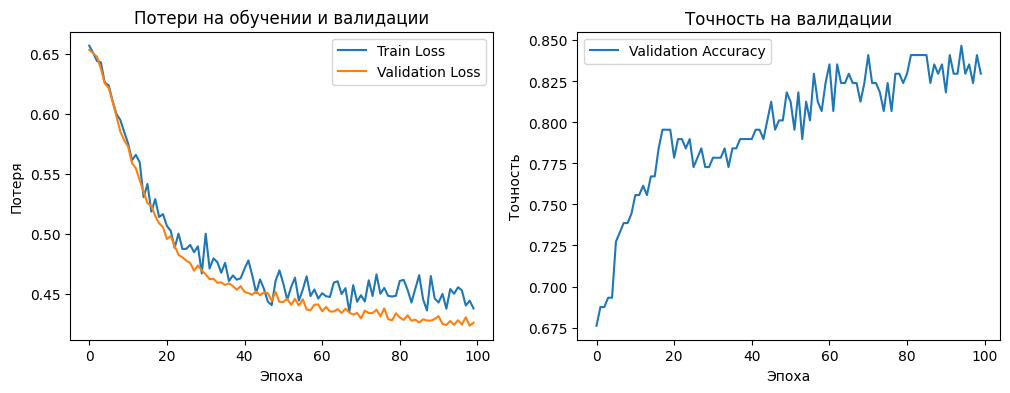

In [290]:
# Предполагаем, что model, criterion, optimizer, train_loader, val_loader уже определены
# Также определим устройство (CPU или GPU, если доступен)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Обучение будет производиться на: {device}")
model.to(device) # Перемещаем модель на выбранное устройство

# Гиперпараметры обучения
num_epochs =  100 # Количество эпох (можно подбирать)
# Можно добавить сохранение логов или метрик
train_losses = []
val_losses = [] # Если будем делать валидацию на каждой эпохе
val_accuracies = [] # Если будем делать валидацию на каждой эпохе

print(f"\nНачинаем обучение на {num_epochs} эпох...")

for epoch in range(num_epochs):
    model.train()
    current_epoch_train_loss = 0.0

    for batch_idx, (features, labels) in enumerate(train_loader):
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        current_epoch_train_loss += loss.item() * features.size(0)
        # if (batch_idx + 1) % 20 == 0:
        #      print(f'Эпоха [{epoch+1}/{num_epochs}], Батч [{batch_idx+1}/{len(train_loader)}], Потеря: {loss.item():.4f}')

    epoch_train_loss = current_epoch_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    
    print(f"--- Конец эпохи [{epoch+1}/{num_epochs}] ---")
    print(f"Средняя потеря на обучении: {epoch_train_loss:.4f}")

    # Цикл валидации (остается почти таким же)
    model.eval()
    current_epoch_val_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for features, labels in val_loader:
            features = features.to(device)
            labels = labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            current_epoch_val_loss += loss.item() * features.size(0)
            predicted_probs = torch.sigmoid(outputs)
            predicted_classes = (predicted_probs > 0.5).float()
            total_samples += labels.size(0)
            correct_predictions += (predicted_classes == labels).sum().item()

    epoch_val_loss = current_epoch_val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_predictions / total_samples
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_accuracy)

    print(f"Средняя потеря на валидации: {epoch_val_loss:.4f}")
    print(f"Точность на валидации: {epoch_val_accuracy:.4f} ({correct_predictions}/{total_samples})")

    # 4. Шаг планировщика скорости обучения
    # Для ReduceLROnPlateau, .step() вызывается с метрикой, за которой он следит.
    scheduler.step(epoch_val_loss) 
    # Для других планировщиков (например, StepLR), .step() вызывается без аргументов: scheduler.step()
    
    # Опционально: вывести текущую скорость обучения
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Текущая скорость обучения: {current_lr:.6f}")
    print("---------------------------------------------------")

print("\nОбучение завершено!")
# Опционально: можно построить графики потерь и точности

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.title('Потери на обучении и валидации')

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.title('Точность на валидации')
plt.show()

### Код для создания submission-файла

In [291]:
model.eval() 

all_predictions = []

# 2. Отключаем вычисление градиентов
with torch.no_grad():
    # 3. Итерация по тестовым данным через DataLoader
    for features_batch in test_loader: # test_loader для тестового набора возвращает только признаки
        # Перемещаем батч на то же устройство, что и модель
        features_batch = features_batch.to(device)
        
        # 4. Получаем логиты от модели
        outputs_logits = model(features_batch)
        
        # 5. Преобразуем логиты в вероятности, затем в предсказанные классы
        predicted_probs = torch.sigmoid(outputs_logits)
        predicted_classes = (predicted_probs > 0.5).int() # .int() для получения 0 или 1
        
        # Собираем предсказания из батча
        # .cpu() - если модель на GPU, нужно перенести тензор на CPU перед конвертацией в NumPy
        # .numpy() - конвертируем тензор в NumPy массив
        # .flatten() - если predicted_classes имеет форму (batch_size, 1), делаем его (batch_size,)
        all_predictions.extend(predicted_classes.cpu().numpy().flatten().tolist())

print(f"Предсказания для {len(all_predictions)} тестовых примеров сгенерированы.")

# 6. Формирование DataFrame для отправки
if 'PassengerId' in df_test_original.columns:
    if len(df_test_original) == len(all_predictions):
        submission_df = pd.DataFrame({
            'PassengerId': df_test_original['PassengerId'],
            'Survived': all_predictions
        })
        
        # 7. Сохранение в CSV-файл
        submission_filename = 'submission_titanic_pytorch.csv'
        submission_df.to_csv(submission_filename, index=False)
        print(f"\nSubmission-файл '{submission_filename}' успешно создан.")
        print("Первые 5 строк submission-файла:")
        print(submission_df.head())
    else:
        print(f"\nОшибка: Количество предсказаний ({len(all_predictions)}) не совпадает "
              f"с количеством строк в df_test_original ({len(df_test_original)}).")
else:
    print("\nОшибка: Столбец 'PassengerId' не найден в df_test_original. Не могу создать submission-файл.")

Предсказания для 418 тестовых примеров сгенерированы.

Submission-файл 'submission_titanic_pytorch.csv' успешно создан.
Первые 5 строк submission-файла:
   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0
